In [5]:
from topology import topology_bayern
from generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_scipy import solve_lp

G = topology_bayern()


In [13]:
vnf_profiles = [
    {"cpu": 2, "throughput": 50, "latency": 50},
    {"cpu": 4, "throughput": 60, "latency": 80},
    {"cpu": 6, "throughput": 70, "latency": 100}
]

# Example: generate 3 slices, each with 2 VNFs
slices = generate_random_slices(G, vnf_profiles, num_slices=3, num_vnfs_per_slice=2)

slices


[([{'id': 'vnf0_0', 'cpu': 6, 'throughput': 70, 'latency': 100, 'slice': 0},
   {'id': 'vnf0_1', 'cpu': 4, 'throughput': 60, 'latency': 80, 'slice': 0}],
  [{'from': 'vnf0_0', 'to': 'vnf0_1', 'bandwidth': 70, 'latency': 100}]),
 ([{'id': 'vnf1_0', 'cpu': 2, 'throughput': 50, 'latency': 50, 'slice': 1},
   {'id': 'vnf1_1', 'cpu': 2, 'throughput': 50, 'latency': 50, 'slice': 1}],
  [{'from': 'vnf1_0', 'to': 'vnf1_1', 'bandwidth': 50, 'latency': 50}]),
 ([{'id': 'vnf2_0', 'cpu': 6, 'throughput': 70, 'latency': 100, 'slice': 2},
   {'id': 'vnf2_1', 'cpu': 2, 'throughput': 50, 'latency': 50, 'slice': 2}],
  [{'from': 'vnf2_0', 'to': 'vnf2_1', 'bandwidth': 70, 'latency': 100}])]

In [7]:
instance = build_instance_from_topology(G, slices)

In [8]:
res, var_index = solve_lp(instance)

print("Objective value:", res.fun)

# Interpret solution (print non-zeros)
for key, idx in var_index.items():
    if abs(res.x[idx]) > 1e-6:
        print(f"{key} = {res.x[idx]:.2f}")


Objective value: 4.8
('v', 'vnf0_0', 3) = 1.00
('v', 'vnf0_1', 1) = 1.00
('v', 'vnf1_0', 6) = 1.00
('v', 'vnf1_1', 3) = 1.00
('v', 'vnf2_0', 1) = 1.00
('v', 'vnf2_1', 4) = 1.00
('u', 1) = 0.60
('z', 1) = 0.60
('u', 3) = 1.00
('z', 3) = 1.00
('u', 4) = 0.60
('z', 4) = 0.60
('u', 6) = 0.20
('z', 6) = 0.20


In [10]:
# All comments in English
import matplotlib.pyplot as plt
import networkx as nx

def plot_solution(G, res, var_index, instance):
    pos = nx.spring_layout(G, seed=42)

    # Collect VNFs per node
    vnfs_per_node = {n: [] for n in instance.N}
    active_nodes = set()
    for key, idx in var_index.items():
        if key[0] == "v" and res.x[idx] > 0.5:
            _, vnf, n = key
            vnfs_per_node[n].append(vnf)
        if key[0] == "z" and res.x[idx] > 0.5:
            _, n = key
            active_nodes.add(n)

    # Node colors: green if active, gray otherwise
    node_colors = []
    for n in G.nodes():
        node_colors.append("lightgreen" if n in active_nodes else "lightgray")

    # Draw base graph
    nx.draw(G, pos, node_color=node_colors, node_size=800, with_labels=False)

    # Labels = node id + VNFs
    labels = {}
    for n in G.nodes():
        if vnfs_per_node[n]:
            labels[n] = f"{n}\n" + ",".join(vnfs_per_node[n])
        else:
            labels[n] = str(n)

    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    # Highlight active links
    active_edges = []
    for key, idx in var_index.items():
        if key[0] == "w" and res.x[idx] > 0.5:
            _, e = key
            active_edges.append(e)
    nx.draw_networkx_edges(G, pos, edgelist=active_edges, edge_color="red", width=2)

    plt.show()


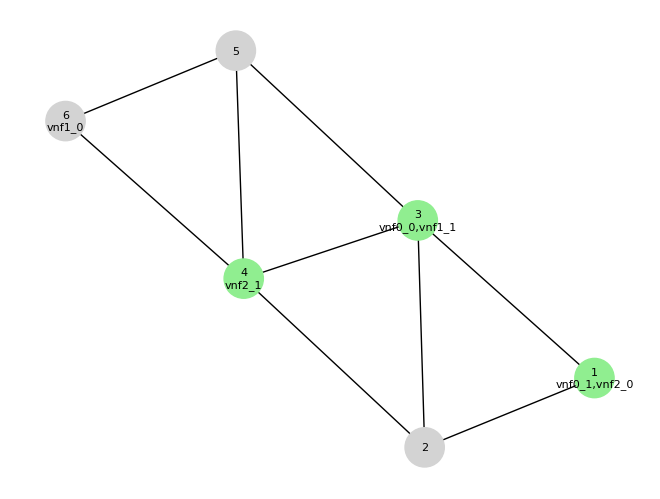

In [12]:
instance = build_instance_from_topology(G, slices)
res, var_index = solve_lp(instance)

plot_solution(G, res, var_index, instance)